### Imports & PySpark Session

In [97]:
import os
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import re
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import glob

In [2]:
spark = SparkSession.builder \
    .master("local[*]") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)
spark.sparkContext.setLogLevel("ERROR")
spark

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/05 09:36:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Bronze Layer
The bronze layer contains raw, unvalidated data. It contains and maintains the raw state of the data source in its original formats, preserving the data's fidelity. It enables reprocessing and auditing by retaining all historical data.

In [3]:
# Raw file locations
lms_csv = "data/lms_loan_daily.csv"
clickstream_csv = "data/feature_clickstream.csv"
attributes_csv = "data/features_attributes.csv"
financials_csv = "data/features_financials.csv"

# Start / End Snapshots
start_date_str = "2023-01-01"
end_date_str = "2024-12-01"

# Bronze Data Stores
bronze_lms_directory = "datamart/bronze/lms/"
bronze_cs_directory = "datamart/bronze/clickstream/"
bronze_att_directory = "datamart/bronze/attributes/"
bronze_fin_directory = "datamart/bronze/financials/"

In [4]:
if not os.path.exists(bronze_lms_directory):
    os.makedirs(bronze_lms_directory)
if not os.path.exists(bronze_cs_directory):
    os.makedirs(bronze_cs_directory)
if not os.path.exists(bronze_att_directory):
    os.makedirs(bronze_att_directory)    
if not os.path.exists(bronze_fin_directory):
    os.makedirs(bronze_fin_directory)

In [5]:
# Load dataframes
df_lms = spark.read.csv(lms_csv, header=True, inferSchema=True)
df_cs = spark.read.csv(clickstream_csv, header=True, inferSchema=True)
df_att = spark.read.csv(attributes_csv, header=True, inferSchema=True)
df_fin = spark.read.csv(financials_csv, header=True, inferSchema=True)
df_lms.createOrReplaceGlobalTempView("df_lms")
df_cs.createOrReplaceGlobalTempView("df_cs")
df_att.createOrReplaceGlobalTempView("df_att")
df_fin.createOrReplaceGlobalTempView("df_fin")

In [6]:
# Verify all snapshot dates are first of the month
n_errors = 0
for df in [df_lms, df_cs, df_att, df_fin]:
    n_errors += df.filter(F.dayofmonth("snapshot_date") != 1).count()
print(f"Number of unexpected snapshot dates: {n_errors}")

Number of unexpected snapshot dates: 0


In [7]:
# Generate snapshot dates
cur_year = datetime.strptime(start_date_str, "%Y-%m-%d").year
cur_month = datetime.strptime(start_date_str, "%Y-%m-%d").month
end_year = datetime.strptime(end_date_str, "%Y-%m-%d").year
end_month = datetime.strptime(end_date_str, "%Y-%m-%d").month

snapshot_dates = []

while cur_year < end_year or (cur_year == end_year and cur_month <= end_month):
    snapshot_dates.append(datetime(cur_year, cur_month, 1))
    if cur_month == 12:
        cur_year += 1
        cur_month = 1
    else:
        cur_month += 1

In [8]:
# Partition into snapshot files
# LMSs
for snapshot_date in snapshot_dates:
    df_partition = df_lms.filter(F.col('snapshot_date') == snapshot_date)
    snapshot_date_str = snapshot_date.strftime("%Y-%m-%d")
    filename = "bronze_lms_" + snapshot_date_str + '.csv'
    filepath = bronze_lms_directory + filename
    df_partition.toPandas().to_csv(filepath, index=False)
    print(f'LMS: {snapshot_date_str}: {df_partition.count()} records saved to: {filepath}')

# Clickstream
for snapshot_date in snapshot_dates:
    df_partition = df_cs.filter(F.col('snapshot_date') == snapshot_date)
    snapshot_date_str = snapshot_date.strftime("%Y-%m-%d")
    filename = "bronze_cs_" + snapshot_date_str + '.csv'
    filepath = bronze_cs_directory + filename
    df_partition.toPandas().to_csv(filepath, index=False)
    print(f'Clickstream: {snapshot_date_str}: {df_partition.count()} records saved to: {filepath}')

# Attributes
for snapshot_date in snapshot_dates:
    df_partition = df_att.filter(F.col('snapshot_date') == snapshot_date)
    snapshot_date_str = snapshot_date.strftime("%Y-%m-%d")
    filename = "bronze_att_" + snapshot_date_str + '.csv'
    filepath = bronze_att_directory + filename
    df_partition.toPandas().to_csv(filepath, index=False)
    print(f'Attributes: {snapshot_date_str}: {df_partition.count()} records saved to: {filepath}')

# Financials
for snapshot_date in snapshot_dates:
    df_partition = df_fin.filter(F.col('snapshot_date') == snapshot_date)
    snapshot_date_str = snapshot_date.strftime("%Y-%m-%d")
    filename = "bronze_fin_" + snapshot_date_str + '.csv'
    filepath = bronze_fin_directory + filename
    df_partition.toPandas().to_csv(filepath, index=False)
    print(f'Financials: {snapshot_date_str}: {df_partition.count()} records saved to: {filepath}')

LMS: 2023-01-01: 530 records saved to: datamart/bronze/lms/bronze_lms_2023-01-01.csv
LMS: 2023-02-01: 1031 records saved to: datamart/bronze/lms/bronze_lms_2023-02-01.csv
LMS: 2023-03-01: 1537 records saved to: datamart/bronze/lms/bronze_lms_2023-03-01.csv
LMS: 2023-04-01: 2047 records saved to: datamart/bronze/lms/bronze_lms_2023-04-01.csv
LMS: 2023-05-01: 2568 records saved to: datamart/bronze/lms/bronze_lms_2023-05-01.csv
LMS: 2023-06-01: 3085 records saved to: datamart/bronze/lms/bronze_lms_2023-06-01.csv
LMS: 2023-07-01: 3556 records saved to: datamart/bronze/lms/bronze_lms_2023-07-01.csv
LMS: 2023-08-01: 4037 records saved to: datamart/bronze/lms/bronze_lms_2023-08-01.csv
LMS: 2023-09-01: 4491 records saved to: datamart/bronze/lms/bronze_lms_2023-09-01.csv
LMS: 2023-10-01: 4978 records saved to: datamart/bronze/lms/bronze_lms_2023-10-01.csv
LMS: 2023-11-01: 5469 records saved to: datamart/bronze/lms/bronze_lms_2023-11-01.csv
LMS: 2023-12-01: 5428 records saved to: datamart/bronze

### Silver Layer
The silver layer represents validated, cleaned, and enriched versions of the data. It is where you perform data cleansing, deduplication, and normalization.

In [9]:
# Bronze directories
bronze_lms_directory = "datamart/bronze/lms/"
bronze_cs_directory = "datamart/bronze/clickstream/"
bronze_att_directory = "datamart/bronze/attributes/"
bronze_fin_directory = "datamart/bronze/financials/"

# Bronze file prefixes
bronze_lms_prefix = "bronze_lms_"
bronze_cs_prefix = "bronze_cs_"
bronze_att_prefix = "bronze_att_"
bronze_fin_prefix = "bronze_fin_"

# Start / End Snapshots
start_date_str = "2023-01-01"
end_date_str = "2024-12-01"

# Silver Data Stores
silver_lms_directory = "datamart/silver/lms/"
silver_cs_directory = "datamart/silver/clickstream/"
silver_att_directory = "datamart/silver/attributes/"
silver_fin_directory = "datamart/silver/financials/"

# Silver file prefixes
silver_lms_prefix = "silver_lms_"
silver_cs_prefix = "silver_cs_"
silver_att_prefix = "silver_att_"
silver_fin_prefix = "silver_fin_"

In [10]:
if not os.path.exists(silver_lms_directory):
    os.makedirs(silver_lms_directory)
if not os.path.exists(silver_cs_directory):
    os.makedirs(silver_cs_directory)
if not os.path.exists(silver_att_directory):
    os.makedirs(silver_att_directory)    
if not os.path.exists(silver_fin_directory):
    os.makedirs(silver_fin_directory)

In [11]:
# Generate snapshot dates
cur_year = datetime.strptime(start_date_str, "%Y-%m-%d").year
cur_month = datetime.strptime(start_date_str, "%Y-%m-%d").month
end_year = datetime.strptime(end_date_str, "%Y-%m-%d").year
end_month = datetime.strptime(end_date_str, "%Y-%m-%d").month

snapshot_dates = []

while cur_year < end_year or (cur_year == end_year and cur_month <= end_month):
    snapshot_dates.append(datetime(cur_year, cur_month, 1))
    if cur_month == 12:
        cur_year += 1
        cur_month = 1
    else:
        cur_month += 1

#### Common Functions

In [12]:
# Remove underscores
def clean_underscores(df, column):
    df = df.withColumn(column, F.regexp_replace(column, "_", ""))
    df = df.withColumn(column, F.when(F.col(column) == '', None).otherwise(F.col(column)))
    return df

#### Attributes

In [13]:
att_column_type_map = {
    "customer_id": T.StringType(),
    "name": T.StringType(),
    "age": T.IntegerType(),
    "ssn": T.StringType(),
    "occupation": T.StringType(),
    "snapshot_date": T.DateType(),
}

##### EDA

In [14]:
df_eda = []
for i in range(len(snapshot_dates)):
    snapshot_date = snapshot_dates[i]
    snapshot_date_str = snapshot_date.strftime("%Y-%m-%d")
    filename = bronze_att_prefix + snapshot_date_str + '.csv'
    filepath = bronze_att_directory + filename
    df_eda.append(spark.read.csv(filepath, header=True, inferSchema=True))

In [15]:
for i in range(len(snapshot_dates)):
    print(f"{snapshot_dates[i].strftime('%Y-%m-%d')}: {df_eda[i].count()} records")
    if i == 0:
        df_all = df_eda[i]
    else:
        df_all = df_all.union(df_eda[i])

2023-01-01: 530 records
2023-02-01: 501 records
2023-03-01: 506 records
2023-04-01: 510 records
2023-05-01: 521 records
2023-06-01: 517 records
2023-07-01: 471 records
2023-08-01: 481 records
2023-09-01: 454 records
2023-10-01: 487 records
2023-11-01: 491 records
2023-12-01: 489 records
2024-01-01: 485 records
2024-02-01: 518 records
2024-03-01: 511 records
2024-04-01: 513 records
2024-05-01: 491 records
2024-06-01: 498 records
2024-07-01: 505 records
2024-08-01: 543 records
2024-09-01: 493 records
2024-10-01: 456 records
2024-11-01: 488 records
2024-12-01: 515 records


In [16]:
print(f'Number of rows: {df_all.count()}')
print(f'Number of distinct rows: {df_all.drop("snapshot_date").distinct().count()}')
print(f'Number of distinct customer IDs: {df_all.select("Customer_ID").distinct().count()}')
print(f'Number of distinct SSNs: {df_all.select("SSN").distinct().count()}')
print(f'Number of erroneous SSNs: {df_all.select("SSN").where(F.col('SSN')=='#F%$D@*&8').count()}')

Number of rows: 11974
Number of distinct rows: 11974
Number of distinct customer IDs: 11974
Number of distinct SSNs: 11299
Number of erroneous SSNs: 676


##### Processing
Bronze dataset contains monthly snapshots of individuals' attributes. Individuals appear to be distinct people (as opposed to the same person being given different Customer IDs), based on analysis of SSN.

Clean up and store cumulative dataset of individual attributes in Silver.

In [17]:
for i in range(len(snapshot_dates)):
    snapshot_date = snapshot_dates[i]
    snapshot_date_str = snapshot_date.strftime("%Y-%m-%d")
    filename = bronze_att_prefix + snapshot_date_str + '.csv'
    filepath = bronze_att_directory + filename

    print(f"===== Opening {filepath} =====")

    df = spark.read.csv(filepath, header=True, inferSchema=False)

    # Convert column headers to lower case
    df = df.toDF(*[c.lower() for c in df.columns])

    # Clean underscores
    for column in ["name", "age", "occupation"]:
        df = clean_underscores(df, column)

    # Cast column types
    for column, new_type in att_column_type_map.items():
        df = df.withColumn(column, F.col(column).cast(new_type))

    # Clean age
    df = df.withColumn("age", F.when(F.col("age") < 1, None).otherwise(F.col("age")))
    df = df.withColumn("age", F.when(F.col("age") > 150, None).otherwise(F.col("age")))

    # Clean name and occupation
    df = df.withColumn("name", F.when(F.col("name")=="", None).otherwise(F.col("name")))
    df = df.withColumn("name", F.regexp_replace(F.col("name"), r'"{3,}', ""))
    df = df.withColumn("occupation", F.when(F.col("occupation")=="", None).otherwise(F.col("occupation")))

    # Clean ssn
    pattern = r"^\d{3}-\d{2}-\d{4}$"
    df = df.withColumn("ssn", F.when(F.col("ssn").rlike(pattern), F.col("ssn")).otherwise(None))

    # Populate null values for categorical variables
    for column in ["ssn", "occupation"]:
        df = df.withColumn(column, F.when(F.col(column).isNull(), "Unknown").otherwise(F.col(column)))

    # Check Null values
    for column in df.columns:
        print(f"{column}: {df.filter(df[column].isNull()).count()} null values")

    # Cumulative file
    if i == 0:
        df_all = df
    else:
        df_all = df_all.union(df)

    # Drop duplicates
    ori_count = df_all.count()
    df_all = df_all.dropDuplicates()
    print(f"{df_all.count() - ori_count} duplicates dropped.")

    # Review
    print(f'Number of rows: {df_all.count()}')

    # Save
    partition_name = silver_att_prefix + snapshot_date_str + '.parquet'
    target_filepath = silver_att_directory + partition_name
    df_all.write.mode("overwrite").parquet(target_filepath)
    print(f'{filepath} saved to: {target_filepath}')

===== Opening datamart/bronze/attributes/bronze_att_2023-01-01.csv =====
customer_id: 0 null values
name: 0 null values
age: 17 null values
ssn: 0 null values
occupation: 0 null values
snapshot_date: 0 null values
0 duplicates dropped.
Number of rows: 530
datamart/bronze/attributes/bronze_att_2023-01-01.csv saved to: datamart/silver/attributes/silver_att_2023-01-01.parquet
===== Opening datamart/bronze/attributes/bronze_att_2023-02-01.csv =====
customer_id: 0 null values
name: 0 null values
age: 11 null values
ssn: 0 null values
occupation: 0 null values
snapshot_date: 0 null values
0 duplicates dropped.
Number of rows: 1031
datamart/bronze/attributes/bronze_att_2023-02-01.csv saved to: datamart/silver/attributes/silver_att_2023-02-01.parquet
===== Opening datamart/bronze/attributes/bronze_att_2023-03-01.csv =====
customer_id: 0 null values
name: 0 null values
age: 17 null values
ssn: 0 null values
occupation: 0 null values
snapshot_date: 0 null values
0 duplicates dropped.
Number of r

#### Clickstream

##### EDA

In [18]:
df_eda = []
for i in range(len(snapshot_dates)):
    snapshot_date = snapshot_dates[i]
    snapshot_date_str = snapshot_date.strftime("%Y-%m-%d")
    filename = bronze_cs_prefix + snapshot_date_str + '.csv'
    filepath = bronze_cs_directory + filename
    df_eda.append(spark.read.csv(filepath, header=True, inferSchema=True))

In [19]:
df_eda[0].show()

+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----------+-------------+
|fe_1|fe_2|fe_3|fe_4|fe_5|fe_6|fe_7|fe_8|fe_9|fe_10|fe_11|fe_12|fe_13|fe_14|fe_15|fe_16|fe_17|fe_18|fe_19|fe_20|Customer_ID|snapshot_date|
+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----------+-------------+
|  63| 118|  80| 121|  55| 193| 111| 112|-101|   83|  164|  105|  -16|  -81| -126|  114|   35|   85|  -73|   76| CUS_0x1037|   2023-01-01|
|-108| 182| 123|   4| -56|  27|  25|  -6| 284|  222|  203|  190|  -14|  -96|  200|   35|  130|   94|  111|   75| CUS_0x1069|   2023-01-01|
| -13|   8|  87| 166| 214| -98| 215| 152| 129|  139|   14|  203|   26|   86|  171|  125| -130|  354|   17|  302| CUS_0x114a|   2023-01-01|
| -85|  45| 200|  89| 128|  54|  76|  51|  61|  139|    6|  197|  172|   96|  174|  163|   37|  207|  180|  118| CUS_0x1184|   2023-01-01|
|  55| 120| 226| -86| 253| 

In [20]:
for i in range(len(snapshot_dates)):
    print(f"{snapshot_dates[i].strftime('%Y-%m-%d')}: {df_eda[i].count()} records")
    if i == 0:
        df_all = df_eda[i]
    else:
        df_all = df_all.union(df_eda[i])

2023-01-01: 8974 records
2023-02-01: 8974 records
2023-03-01: 8974 records
2023-04-01: 8974 records
2023-05-01: 8974 records
2023-06-01: 8974 records
2023-07-01: 8974 records
2023-08-01: 8974 records
2023-09-01: 8974 records
2023-10-01: 8974 records
2023-11-01: 8974 records
2023-12-01: 8974 records
2024-01-01: 8974 records
2024-02-01: 8974 records
2024-03-01: 8974 records
2024-04-01: 8974 records
2024-05-01: 8974 records
2024-06-01: 8974 records
2024-07-01: 8974 records
2024-08-01: 8974 records
2024-09-01: 8974 records
2024-10-01: 8974 records
2024-11-01: 8974 records
2024-12-01: 8974 records


In [21]:
print(f'Number of rows: {df_all.count()}')
print(f'Number of distinct rows: {df_all.drop("snapshot_date").distinct().count()}')
print(f'Number of distinct customer IDs: {df_all.select("Customer_ID").distinct().count()}')

Number of rows: 215376
Number of distinct rows: 215376
Number of distinct customer IDs: 8974


In [22]:
df_all.drop("snapshot_date").groupBy("Customer_ID").count().show()
df_all.where(F.col('Customer_ID') == 'CUS_0x74c7').show()

+-----------+-----+
|Customer_ID|count|
+-----------+-----+
| CUS_0x6ba9|   24|
| CUS_0x74c7|   24|
|  CUS_0xc65|   24|
| CUS_0x5a8b|   24|
| CUS_0x78d3|   24|
| CUS_0x7f5d|   24|
| CUS_0x8eb2|   24|
|  CUS_0xf6c|   24|
| CUS_0x7e24|   24|
| CUS_0xc65a|   24|
|  CUS_0xebe|   24|
| CUS_0x1ed5|   24|
| CUS_0x5479|   24|
| CUS_0x7e8d|   24|
| CUS_0xb38d|   24|
| CUS_0xafeb|   24|
| CUS_0x1b0f|   24|
| CUS_0x834f|   24|
| CUS_0x856b|   24|
| CUS_0x8d3d|   24|
+-----------+-----+
only showing top 20 rows
+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----------+-------------+
|fe_1|fe_2|fe_3|fe_4|fe_5|fe_6|fe_7|fe_8|fe_9|fe_10|fe_11|fe_12|fe_13|fe_14|fe_15|fe_16|fe_17|fe_18|fe_19|fe_20|Customer_ID|snapshot_date|
+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----------+-------------+
| 203| 109| 306|  47| 222|  49|  38|  97| 126|  196|  190|  100|  156|   80|  

##### Processing
Bronze dataset contains monthly snapshot data. Store snapshot clickstream of the same 8974 customers.

In [23]:
cs_column_type_map = {
    "fe_1": T.IntegerType(),
    "fe_2": T.IntegerType(),
    "fe_3": T.IntegerType(),
    "fe_4": T.IntegerType(),
    "fe_5": T.IntegerType(),
    "fe_6": T.IntegerType(),
    "fe_7": T.IntegerType(),
    "fe_8": T.IntegerType(),
    "fe_9": T.IntegerType(),
    "fe_10": T.IntegerType(),
    "fe_11": T.IntegerType(),
    "fe_12": T.IntegerType(),
    "fe_13": T.IntegerType(),
    "fe_14": T.IntegerType(),
    "fe_15": T.IntegerType(),
    "fe_16": T.IntegerType(),
    "fe_17": T.IntegerType(),
    "fe_18": T.IntegerType(),
    "fe_19": T.IntegerType(),
    "fe_20": T.IntegerType(),
    "customer_id": T.StringType(),
    "snapshot_date": T.DateType()
}

In [24]:
for i in range(len(snapshot_dates)):
    snapshot_date = snapshot_dates[i]
    snapshot_date_str = snapshot_date.strftime("%Y-%m-%d")
    filename = bronze_cs_prefix + snapshot_date_str + '.csv'
    filepath = bronze_cs_directory + filename

    print(f"===== Opening {filepath} =====")

    df = spark.read.csv(filepath, header=True, inferSchema=False)

    # Convert column headers to lower case
    df = df.toDF(*[c.lower() for c in df.columns])

    # Cast column types
    for column, new_type in cs_column_type_map.items():
        df_all = df_all.withColumn(column, F.col(column).cast(new_type))

    # Cumulative file
    if i == 0:
        df_all = df
    else:
        df_all = df_all.union(df)

    # Drop duplicates
    ori_count = df_all.count()
    df_all = df_all.dropDuplicates()
    print(f"{df_all.count() - ori_count} duplicates dropped.")
    
    # Review
    print(f'Number of rows: {df_all.count()}')

    # Save
    partition_name = silver_cs_prefix + snapshot_date_str + '.parquet'
    target_filepath = silver_cs_directory + partition_name
    df_all.write.mode("overwrite").parquet(target_filepath)
    print(f'{filepath} saved to: {target_filepath}')

===== Opening datamart/bronze/clickstream/bronze_cs_2023-01-01.csv =====
0 duplicates dropped.
Number of rows: 8974
datamart/bronze/clickstream/bronze_cs_2023-01-01.csv saved to: datamart/silver/clickstream/silver_cs_2023-01-01.parquet
===== Opening datamart/bronze/clickstream/bronze_cs_2023-02-01.csv =====
0 duplicates dropped.
Number of rows: 17948
datamart/bronze/clickstream/bronze_cs_2023-02-01.csv saved to: datamart/silver/clickstream/silver_cs_2023-02-01.parquet
===== Opening datamart/bronze/clickstream/bronze_cs_2023-03-01.csv =====
0 duplicates dropped.
Number of rows: 26922
datamart/bronze/clickstream/bronze_cs_2023-03-01.csv saved to: datamart/silver/clickstream/silver_cs_2023-03-01.parquet
===== Opening datamart/bronze/clickstream/bronze_cs_2023-04-01.csv =====
0 duplicates dropped.
Number of rows: 35896
datamart/bronze/clickstream/bronze_cs_2023-04-01.csv saved to: datamart/silver/clickstream/silver_cs_2023-04-01.parquet
===== Opening datamart/bronze/clickstream/bronze_cs_2

Number of rows: 116662
datamart/bronze/clickstream/bronze_cs_2024-01-01.csv saved to: datamart/silver/clickstream/silver_cs_2024-01-01.parquet
===== Opening datamart/bronze/clickstream/bronze_cs_2024-02-01.csv =====
0 duplicates dropped.
Number of rows: 125636
datamart/bronze/clickstream/bronze_cs_2024-02-01.csv saved to: datamart/silver/clickstream/silver_cs_2024-02-01.parquet
===== Opening datamart/bronze/clickstream/bronze_cs_2024-03-01.csv =====
0 duplicates dropped.
Number of rows: 134610
datamart/bronze/clickstream/bronze_cs_2024-03-01.csv saved to: datamart/silver/clickstream/silver_cs_2024-03-01.parquet
===== Opening datamart/bronze/clickstream/bronze_cs_2024-04-01.csv =====
0 duplicates dropped.
Number of rows: 143584
datamart/bronze/clickstream/bronze_cs_2024-04-01.csv saved to: datamart/silver/clickstream/silver_cs_2024-04-01.parquet
===== Opening datamart/bronze/clickstream/bronze_cs_2024-05-01.csv =====


0 duplicates dropped.
Number of rows: 152558
datamart/bronze/clickstream/bronze_cs_2024-05-01.csv saved to: datamart/silver/clickstream/silver_cs_2024-05-01.parquet
===== Opening datamart/bronze/clickstream/bronze_cs_2024-06-01.csv =====
0 duplicates dropped.
Number of rows: 161532
datamart/bronze/clickstream/bronze_cs_2024-06-01.csv saved to: datamart/silver/clickstream/silver_cs_2024-06-01.parquet
===== Opening datamart/bronze/clickstream/bronze_cs_2024-07-01.csv =====


0 duplicates dropped.
Number of rows: 170506
datamart/bronze/clickstream/bronze_cs_2024-07-01.csv saved to: datamart/silver/clickstream/silver_cs_2024-07-01.parquet
===== Opening datamart/bronze/clickstream/bronze_cs_2024-08-01.csv =====


0 duplicates dropped.
Number of rows: 179480
datamart/bronze/clickstream/bronze_cs_2024-08-01.csv saved to: datamart/silver/clickstream/silver_cs_2024-08-01.parquet
===== Opening datamart/bronze/clickstream/bronze_cs_2024-09-01.csv =====


0 duplicates dropped.
Number of rows: 188454
datamart/bronze/clickstream/bronze_cs_2024-09-01.csv saved to: datamart/silver/clickstream/silver_cs_2024-09-01.parquet
===== Opening datamart/bronze/clickstream/bronze_cs_2024-10-01.csv =====


0 duplicates dropped.
Number of rows: 197428
datamart/bronze/clickstream/bronze_cs_2024-10-01.csv saved to: datamart/silver/clickstream/silver_cs_2024-10-01.parquet
===== Opening datamart/bronze/clickstream/bronze_cs_2024-11-01.csv =====


0 duplicates dropped.


Number of rows: 206402
datamart/bronze/clickstream/bronze_cs_2024-11-01.csv saved to: datamart/silver/clickstream/silver_cs_2024-11-01.parquet
===== Opening datamart/bronze/clickstream/bronze_cs_2024-12-01.csv =====


0 duplicates dropped.


Number of rows: 215376
datamart/bronze/clickstream/bronze_cs_2024-12-01.csv saved to: datamart/silver/clickstream/silver_cs_2024-12-01.parquet


#### Financials

##### EDA

In [25]:
df_eda = []
for i in range(len(snapshot_dates)):
    snapshot_date = snapshot_dates[i]
    snapshot_date_str = snapshot_date.strftime("%Y-%m-%d")
    filename = bronze_fin_prefix + snapshot_date_str + '.csv'
    filepath = bronze_fin_directory + filename
    df_eda.append(spark.read.csv(filepath, header=True, inferSchema=False))

In [26]:
df_eda[0].show()

+-----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+------------------+-------------+
|Customer_ID|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|   Monthly_Balance|snapshot_date|
+-----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+-------

In [27]:
for i in range(len(snapshot_dates)):
    if i == 0:
        df_all = df_eda[i]
    else:
        df_all = df_all.union(df_eda[i])
    print(f"{snapshot_dates[i].strftime('%Y-%m-%d')}: {df_eda[i].count()} records added, total: {df_all.count()}")


2023-01-01: 530 records added, total: 530
2023-02-01: 501 records added, total: 1031
2023-03-01: 506 records added, total: 1537
2023-04-01: 510 records added, total: 2047
2023-05-01: 521 records added, total: 2568
2023-06-01: 517 records added, total: 3085
2023-07-01: 471 records added, total: 3556
2023-08-01: 481 records added, total: 4037
2023-09-01: 454 records added, total: 4491
2023-10-01: 487 records added, total: 4978
2023-11-01: 491 records added, total: 5469
2023-12-01: 489 records added, total: 5958
2024-01-01: 485 records added, total: 6443
2024-02-01: 518 records added, total: 6961
2024-03-01: 511 records added, total: 7472
2024-04-01: 513 records added, total: 7985
2024-05-01: 491 records added, total: 8476
2024-06-01: 498 records added, total: 8974
2024-07-01: 505 records added, total: 9479
2024-08-01: 543 records added, total: 10022
2024-09-01: 493 records added, total: 10515
2024-10-01: 456 records added, total: 10971
2024-11-01: 488 records added, total: 11459
2024-12-

In [28]:
print(f'Number of rows: {df_all.count()}')
print(f'Number of distinct rows: {df_all.drop("snapshot_date").distinct().count()}')
print(f'Number of distinct customer IDs: {df_all.select("Customer_ID").distinct().count()}')

Number of rows: 11974
Number of distinct rows: 11974
Number of distinct customer IDs: 11974


In [29]:
df_all.summary().show()

+-------+-----------+------------------+---------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+------------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+--------------------+-------------+
|summary|Customer_ID|     Annual_Income|Monthly_Inhand_Salary| Num_Bank_Accounts|   Num_Credit_Card|     Interest_Rate|       Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|  Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|     Monthly_Balance|snapshot_date|
+-------+-----------+------------------+---------------------+------------------+------------------+--------------

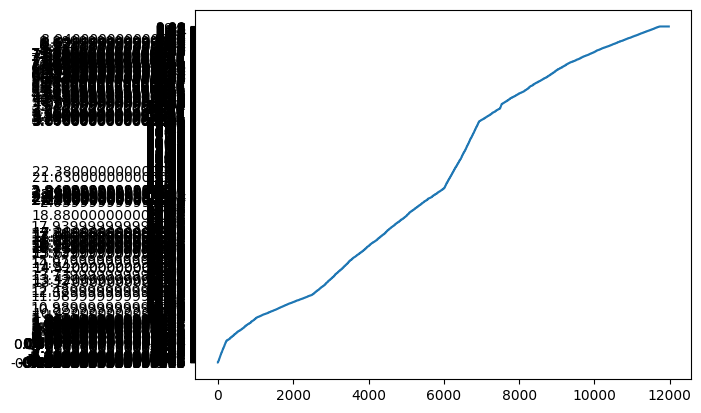

In [30]:
# Negative values in changed_credit_limit are valid.
test_plot = df_all.select("changed_credit_limit").orderBy("changed_credit_limit").dropna().toPandas()
plt.plot(test_plot["changed_credit_limit"].values)
plt.show()

##### Processing
Bronze dataset contains monthly snapshots of individuals' financials information. Clients do not repeat.

Clean up and store cumulative dataset of all individuals' financials in Silver.

In [31]:
fin_column_type_map = {
    "customer_id": T.StringType(),
    "annual_income": T.FloatType(),
    "monthly_inhand_salary": T.FloatType(),
    "num_bank_accounts": T.IntegerType(),
    "num_credit_card": T.IntegerType(),
    "interest_rate": T.IntegerType(),
    "num_of_loan": T.IntegerType(),
    "type_of_loan": T.StringType(),
    "delay_from_due_date": T.IntegerType(),
    "num_of_delayed_payment": T.IntegerType(),
    "changed_credit_limit": T.FloatType(),
    "num_credit_inquiries": T.IntegerType(),
    "credit_mix": T.StringType(),
    "outstanding_debt": T.FloatType(),
    "credit_utilization_ratio": T.FloatType(),
    "credit_history_age": T.StringType(),
    "payment_of_min_amount": T.StringType(),
    "total_emi_per_month": T.FloatType(),
    "amount_invested_monthly": T.FloatType(),
    "payment_behaviour": T.StringType(),
    "monthly_balance": T.FloatType(),
    "snapshot_date": T.DateType()
}

In [32]:
for i in range(len(snapshot_dates)):
    snapshot_date = snapshot_dates[i]
    snapshot_date_str = snapshot_date.strftime("%Y-%m-%d")
    filename = bronze_fin_prefix + snapshot_date_str + '.csv'
    filepath = bronze_fin_directory + filename

    print(f"===== Opening {filepath} =====")

    df = spark.read.csv(filepath, header=True, inferSchema=False)

    # Convert column headers to lower case
    df = df.toDF(*[c.lower() for c in df.columns])

    # Clean underscores
    for column in ["annual_income", "monthly_inhand_salary", "num_bank_accounts", "num_credit_card", "interest_rate", "num_of_loan", "delay_from_due_date", "num_of_delayed_payment", "changed_credit_limit", "num_credit_inquiries", "outstanding_debt", "credit_utilization_ratio", "total_emi_per_month", "amount_invested_monthly", "monthly_balance", "credit_mix"]:
        df = clean_underscores(df, column)

    # Clean payment behaviour
    df = df.withColumn("payment_behaviour", F.when(F.length(F.col("payment_behaviour")) <10, None).otherwise(F.col("payment_behaviour")))

    # Clean negative values
    for column in ['num_of_loan', 'num_credit_card', 'num_bank_accounts', 'delay_from_due_date', 'num_of_delayed_payment']:
        df = df.withColumn(column, F.when(F.col(column) < 0, None).otherwise(F.col(column)))

    # Clean empty
    for column in df.columns:
        df = df.withColumn(column, F.when(F.col(column) == "", None).otherwise(F.col(column)))
        df = df.withColumn(column, F.when(F.col(column).isNull(), None).otherwise(F.col(column)))

    # Cast column types
    for column, new_type in fin_column_type_map.items():
        if new_type == T.IntegerType():
            df = df.withColumn(column, F.col(column).cast(T.FloatType()))
        df = df.withColumn(column, F.col(column).cast(new_type))

    # # Populate null values for categorical variables
    for column in ["credit_mix", "payment_behaviour", "type_of_loan"]:
        df = df.withColumn(column, F.when(F.col(column).isNull(), "Unknown").otherwise(F.col(column)))

    # Check Null values
    for column in df.columns:
        if df.select(column).where(F.col(column).isNull()).count() > 0:
            print(f"{column}: {df.select(column).where(F.col(column).isNull()).count()} null values")

    # Cumulative file
    if i == 0:
        df_all = df
    else:
        df_all = df_all.union(df)

    # Drop duplicates
    ori_count = df_all.count()
    df_all = df_all.dropDuplicates()
    print(f"{df_all.count() - ori_count} duplicates dropped.")

    # Review
    print(f'Number of rows: {df_all.count()}')

    # Save
    partition_name = silver_fin_prefix + snapshot_date_str + '.parquet'
    target_filepath = silver_fin_directory + partition_name
    df_all.write.mode("overwrite").parquet(target_filepath)
    print(f'{filepath} saved to: {target_filepath}')


===== Opening datamart/bronze/financials/bronze_fin_2023-01-01.csv =====
num_of_loan: 25 null values
delay_from_due_date: 6 null values
num_of_delayed_payment: 1 null values
changed_credit_limit: 16 null values
0 duplicates dropped.
Number of rows: 530
datamart/bronze/financials/bronze_fin_2023-01-01.csv saved to: datamart/silver/financials/silver_fin_2023-01-01.parquet
===== Opening datamart/bronze/financials/bronze_fin_2023-02-01.csv =====
num_of_loan: 20 null values
delay_from_due_date: 1 null values
num_of_delayed_payment: 9 null values
changed_credit_limit: 15 null values
0 duplicates dropped.
Number of rows: 1031
datamart/bronze/financials/bronze_fin_2023-02-01.csv saved to: datamart/silver/financials/silver_fin_2023-02-01.parquet
===== Opening datamart/bronze/financials/bronze_fin_2023-03-01.csv =====
num_of_loan: 19 null values
delay_from_due_date: 1 null values
num_of_delayed_payment: 5 null values
changed_credit_limit: 11 null values
0 duplicates dropped.
Number of rows: 1537

0 duplicates dropped.
Number of rows: 11459
datamart/bronze/financials/bronze_fin_2024-11-01.csv saved to: datamart/silver/financials/silver_fin_2024-11-01.parquet
===== Opening datamart/bronze/financials/bronze_fin_2024-12-01.csv =====
num_of_loan: 29 null values
delay_from_due_date: 3 null values
num_of_delayed_payment: 6 null values
changed_credit_limit: 10 null values


0 duplicates dropped.
Number of rows: 11974
datamart/bronze/financials/bronze_fin_2024-12-01.csv saved to: datamart/silver/financials/silver_fin_2024-12-01.parquet


In [33]:
df_all.show(20)
df_all.summary().show()

+-----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+---------------+-------------+
|customer_id|annual_income|monthly_inhand_salary|num_bank_accounts|num_credit_card|interest_rate|num_of_loan|        type_of_loan|delay_from_due_date|num_of_delayed_payment|changed_credit_limit|num_credit_inquiries|credit_mix|outstanding_debt|credit_utilization_ratio|  credit_history_age|payment_of_min_amount|total_emi_per_month|amount_invested_monthly|   payment_behaviour|monthly_balance|snapshot_date|
+-----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+-------------

+-------+-----------+------------------+---------------------+------------------+------------------+-----------------+------------------+------------+-------------------+----------------------+--------------------+--------------------+----------+------------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+--------------------+
|summary|customer_id|     annual_income|monthly_inhand_salary| num_bank_accounts|   num_credit_card|    interest_rate|       num_of_loan|type_of_loan|delay_from_due_date|num_of_delayed_payment|changed_credit_limit|num_credit_inquiries|credit_mix|  outstanding_debt|credit_utilization_ratio|  credit_history_age|payment_of_min_amount|total_emi_per_month|amount_invested_monthly|   payment_behaviour|     monthly_balance|
+-------+-----------+------------------+---------------------+------------------+------------------+-----------------+------------------+------------+----------

#### Loan Management System

##### EDA

In [34]:
df_eda = []
for i in range(len(snapshot_dates)):
    snapshot_date = snapshot_dates[i]
    snapshot_date_str = snapshot_date.strftime("%Y-%m-%d")
    filename = bronze_lms_prefix + snapshot_date_str + '.csv'
    filepath = bronze_lms_directory + filename
    df_eda.append(spark.read.csv(filepath, header=True, inferSchema=False))

In [35]:
df_eda[0].show()

+--------------------+-----------+---------------+------+---------------+--------+-------+--------+-----------+-------+-------------+
|             loan_id|Customer_ID|loan_start_date|tenure|installment_num|loan_amt|due_amt|paid_amt|overdue_amt|balance|snapshot_date|
+--------------------+-----------+---------------+------+---------------+--------+-------+--------+-----------+-------+-------------+
|CUS_0x1037_2023_0...| CUS_0x1037|     2023-01-01|    10|              0|   10000|    0.0|     0.0|        0.0|10000.0|   2023-01-01|
|CUS_0x1069_2023_0...| CUS_0x1069|     2023-01-01|    10|              0|   10000|    0.0|     0.0|        0.0|10000.0|   2023-01-01|
|CUS_0x114a_2023_0...| CUS_0x114a|     2023-01-01|    10|              0|   10000|    0.0|     0.0|        0.0|10000.0|   2023-01-01|
|CUS_0x1184_2023_0...| CUS_0x1184|     2023-01-01|    10|              0|   10000|    0.0|     0.0|        0.0|10000.0|   2023-01-01|
|CUS_0x1297_2023_0...| CUS_0x1297|     2023-01-01|    10|     

In [36]:
for i in range(len(snapshot_dates)):
    if i == 0:
        df_all = df_eda[i]
    else:
        df_all = df_all.union(df_eda[i])
    print(f"{snapshot_dates[i].strftime('%Y-%m-%d')}: {df_eda[i].count()} records added, total: {df_all.count()}")


2023-01-01: 530 records added, total: 530
2023-02-01: 1031 records added, total: 1561
2023-03-01: 1537 records added, total: 3098
2023-04-01: 2047 records added, total: 5145
2023-05-01: 2568 records added, total: 7713
2023-06-01: 3085 records added, total: 10798
2023-07-01: 3556 records added, total: 14354
2023-08-01: 4037 records added, total: 18391
2023-09-01: 4491 records added, total: 22882
2023-10-01: 4978 records added, total: 27860
2023-11-01: 5469 records added, total: 33329
2023-12-01: 5428 records added, total: 38757
2024-01-01: 5412 records added, total: 44169
2024-02-01: 5424 records added, total: 49593
2024-03-01: 5425 records added, total: 55018
2024-04-01: 5417 records added, total: 60435
2024-05-01: 5391 records added, total: 65826
2024-06-01: 5418 records added, total: 71244
2024-07-01: 5442 records added, total: 76686
2024-08-01: 5531 records added, total: 82217
2024-09-01: 5537 records added, total: 87754
2024-10-01: 5502 records added, total: 93256
2024-11-01: 5501 

In [37]:
print(f'Number of rows: {df_all.count()}')
print(f'Number of distinct rows: {df_all.drop("snapshot_date").distinct().count()}')
print(f'Number of distinct customer IDs: {df_all.select("Customer_ID").distinct().count()}')
print(f'Number of distinct loan IDs: {df_all.select("loan_id").distinct().count()}')
print(f'Number of records per customer IDs: {df_all.groupBy("Customer_ID").count().orderBy("count", ascending=False).show()}')

print(f'Number of loans per customer:')
df_all.groupBy('Customer_ID').agg(F.countDistinct('loan_id')).orderBy("count(distinct loan_id)", ascending=False).show()


Number of rows: 104288
Number of distinct rows: 104288
Number of distinct customer IDs: 11974
Number of distinct loan IDs: 11974
+-----------+-----+
|Customer_ID|count|
+-----------+-----+
| CUS_0x1b66|   11|
| CUS_0x2abc|   11|
|  CUS_0x75e|   11|
| CUS_0x7910|   11|
| CUS_0x79ac|   11|
| CUS_0x1630|   11|
| CUS_0x3231|   11|
| CUS_0xadb2|   11|
| CUS_0x8a44|   11|
| CUS_0x3a03|   11|
| CUS_0x3e2d|   11|
| CUS_0xae51|   11|
| CUS_0xc1b4|   11|
| CUS_0x21dc|   11|
| CUS_0x2e20|   11|
| CUS_0x4096|   11|
| CUS_0x97bd|   11|
| CUS_0x4688|   11|
| CUS_0x3733|   11|
|  CUS_0x537|   11|
+-----------+-----+
only showing top 20 rows
Number of records per customer IDs: None
Number of loans per customer:
+-----------+-----------------------+
|Customer_ID|count(DISTINCT loan_id)|
+-----------+-----------------------+
| CUS_0xa980|                      1|
| CUS_0x6371|                      1|
| CUS_0x5e1f|                      1|
| CUS_0x1844|                      1|
| CUS_0x856b|                

In [38]:
df_all.summary().show()

+-------+--------------------+-----------+---------------+------+-----------------+--------+-----------------+------------------+-----------------+-----------------+-------------+
|summary|             loan_id|Customer_ID|loan_start_date|tenure|  installment_num|loan_amt|          due_amt|          paid_amt|      overdue_amt|          balance|snapshot_date|
+-------+--------------------+-----------+---------------+------+-----------------+--------+-----------------+------------------+-----------------+-----------------+-------------+
|  count|              104288|     104288|         104288|104288|           104288|  104288|           104288|            104288|           104288|           104288|       104288|
|   mean|                NULL|       NULL|           NULL|  10.0|4.471684182264498| 10000.0|885.1833384473765| 704.4051089291194|747.9575790119669|6276.273396747469|         NULL|
| stddev|                NULL|       NULL|           NULL|   0.0|3.116240553153163|     0.0|318.8020

##### Processing

In [42]:
lms_column_type_map = {
        "loan_id": T.StringType(),
        "customer_id": T.StringType(),
        "loan_start_date": T.DateType(),
        "tenure": T.IntegerType(),
        "installment_num": T.IntegerType(),
        "loan_amt": T.FloatType(),
        "due_amt": T.FloatType(),
        "paid_amt": T.FloatType(),
        "overdue_amt": T.FloatType(),
        "balance": T.FloatType(),
        "snapshot_date": T.DateType()
}

In [43]:
for i in range(len(snapshot_dates)):
    snapshot_date = snapshot_dates[i]
    snapshot_date_str = snapshot_date.strftime("%Y-%m-%d")
    filename = bronze_lms_prefix + snapshot_date_str + '.csv'
    filepath = bronze_lms_directory + filename

    print(f"===== {filepath} =====")

    df = spark.read.csv(filepath, header=True, inferSchema=False)

    # Convert column headers to lower case
    df = df.toDF(*[c.lower() for c in df.columns])

    # Drop duplicates
    ori_count = df.count()
    df = df.dropDuplicates()
    print(f"{df.count() - ori_count} duplicates dropped.")

    # Cast column types
    for column, new_type in lms_column_type_map.items():
        df = df.withColumn(column, F.col(column).cast(new_type))

    # Check Null values
    for column in df.columns:
        if df.select(column).where(F.col(column).isNull()).count() > 0:
            print(f"{column}: {df.select(column).where(F.col(column).isNull()).count()} null values")

    # augment data: add month on book
    df = df.withColumn("mob", F.col("installment_num").cast(T.IntegerType()))

    # augment data: add days past due
    df = df.withColumn("installments_missed", F.when(F.col("due_amt") == 0, 0).otherwise(F.ceil(F.col("overdue_amt") / F.col("due_amt")).cast(T.IntegerType()))).fillna(0)
    df = df.withColumn("first_missed_date", F.when(F.col("installments_missed") > 0, F.add_months(F.col("snapshot_date"), -1 * F.col("installments_missed"))).cast(T.DateType()))
    df = df.withColumn("dpd", F.when(F.col("overdue_amt") > 0.0, F.datediff(F.col("snapshot_date"), F.col("first_missed_date"))).otherwise(0).cast(T.IntegerType()))

    # Cumulative file
    if i == 0:
        df_all = df
    else:
        df_all = df_all.union(df)

    # Review
    print(f'Number of rows: {df_all.count()}')

    # Save
    partition_name = silver_lms_prefix + snapshot_date_str + '.parquet'
    target_filepath = silver_lms_directory + partition_name
    df_all.write.mode("overwrite").parquet(target_filepath)
    print(f'{filepath} saved to: {target_filepath}')


===== datamart/bronze/lms/bronze_lms_2023-01-01.csv =====
0 duplicates dropped.
Number of rows: 530
datamart/bronze/lms/bronze_lms_2023-01-01.csv saved to: datamart/silver/lms/silver_lms_2023-01-01.parquet
===== datamart/bronze/lms/bronze_lms_2023-02-01.csv =====
0 duplicates dropped.
Number of rows: 1561
datamart/bronze/lms/bronze_lms_2023-02-01.csv saved to: datamart/silver/lms/silver_lms_2023-02-01.parquet
===== datamart/bronze/lms/bronze_lms_2023-03-01.csv =====
0 duplicates dropped.
Number of rows: 3098
datamart/bronze/lms/bronze_lms_2023-03-01.csv saved to: datamart/silver/lms/silver_lms_2023-03-01.parquet
===== datamart/bronze/lms/bronze_lms_2023-04-01.csv =====
0 duplicates dropped.
Number of rows: 5145
datamart/bronze/lms/bronze_lms_2023-04-01.csv saved to: datamart/silver/lms/silver_lms_2023-04-01.parquet
===== datamart/bronze/lms/bronze_lms_2023-05-01.csv =====
0 duplicates dropped.
Number of rows: 7713
datamart/bronze/lms/bronze_lms_2023-05-01.csv saved to: datamart/silver/

### Gold Layer

In [44]:
# Silver directories
silver_lms_directory = "datamart/silver/lms/"
silver_cs_directory = "datamart/silver/clickstream/"
silver_att_directory = "datamart/silver/attributes/"
silver_fin_directory = "datamart/silver/financials/"

# Silver file prefixes
silver_lms_prefix = "silver_lms_"
silver_cs_prefix = "silver_cs_"
silver_att_prefix = "silver_att_"
silver_fin_prefix = "silver_fin_"

# Start / End Snapshots
start_date_str = "2023-01-01"
end_date_str = "2024-12-01"

# Reference Date
reference_date = "2024-03-01"

# Gold Data Stores
gold_label_directory = "datamart/gold/label/"
gold_feature_directory = "datamart/gold/feature/"
gold_training_view = "datamart/gold/train_view/"
gold_validation_view = "datamart/gold/validation_view/"
gold_testing_view = "datamart/gold/test_view/"
gold_oot_view = "datamart/gold/oot_view/"

# Gold file prefixes
gold_label_prefix = "gold_label_"
gold_feature_prefix = "gold_feature_"
gold_training_prefix = "gold_train_"
gold_validation_prefix = "gold_valid_"
gold_testing_prefix = "gold_test_"
gold_oot_prefix = "gold_oot_"

In [45]:
if not os.path.exists(gold_label_directory):
    os.makedirs(gold_label_directory)
if not os.path.exists(gold_feature_directory):
    os.makedirs(gold_feature_directory)
if not os.path.exists(gold_training_view):
    os.makedirs(gold_training_view)
if not os.path.exists(gold_validation_view):
    os.makedirs(gold_validation_view)
if not os.path.exists(gold_testing_view):
    os.makedirs(gold_testing_view)
if not os.path.exists(gold_oot_view):
    os.makedirs(gold_oot_view)

In [46]:
# Generate snapshot dates
cur_year = datetime.strptime(start_date_str, "%Y-%m-%d").year
cur_month = datetime.strptime(start_date_str, "%Y-%m-%d").month
end_year = datetime.strptime(end_date_str, "%Y-%m-%d").year
end_month = datetime.strptime(end_date_str, "%Y-%m-%d").month

snapshot_dates = []

while cur_year < end_year or (cur_year == end_year and cur_month <= end_month):
    snapshot_dates.append(datetime(cur_year, cur_month, 1))
    if cur_month == 12:
        cur_year += 1
        cur_month = 1
    else:
        cur_month += 1

#### Gold Label Store

In [47]:
# Label definition (As given in assignment)
dpd = 30 # Days past due
mob = 6 # Month on book

In [48]:
snapshot_date = datetime.strptime(end_date_str, "%Y-%m-%d")
snapshot_date_str = end_date_str

filename = silver_lms_prefix + snapshot_date_str + '.parquet'
filepath = silver_lms_directory + filename
df = spark.read.parquet(filepath)
print('loaded from:', filepath, 'row count:', df.count())

df = df.filter(F.col("mob") == mob)

# get label
df = df.withColumn("label", F.when(F.col("dpd") >= dpd, 1).otherwise(0).cast(T.IntegerType()))
df = df.withColumn("label_def", F.lit(str(dpd)+'dpd_'+str(mob)+'mob').cast(T.StringType()))

# select columns to save
df = df.select("loan_id", "customer_id", "loan_start_date", "label", "label_def", "snapshot_date")

# save gold table - IRL connect to database to write
partition_name = gold_label_prefix + snapshot_date_str + '_' + str(dpd) + 'dpd_' + str(mob) + 'mob.parquet'
filepath = gold_label_directory + partition_name
df.write.mode("overwrite").parquet(filepath)
print('saved to:', filepath)

loaded from: datamart/silver/lms/silver_lms_2024-12-01.parquet row count: 104288
saved to: datamart/gold/label/gold_label_2024-12-01_30dpd_6mob.parquet


#### Gold Feature Store

In [49]:
# Get all cumulative records
snapshot_date = datetime.strptime(end_date_str, "%Y-%m-%d")
snapshot_date_str = end_date_str

filename = silver_att_prefix + snapshot_date_str + '.parquet'
filepath = silver_att_directory + filename
df_att = spark.read.parquet(filepath)
print('loaded from:', filepath, 'row count:', df_att.count())

filename = silver_fin_prefix + snapshot_date_str + '.parquet'
filepath = silver_fin_directory + filename
df_fin = spark.read.parquet(filepath)
print('loaded from:', filepath, 'row count:', df_fin.count())

loaded from: datamart/silver/attributes/silver_att_2024-12-01.parquet row count: 11974
loaded from: datamart/silver/financials/silver_fin_2024-12-01.parquet row count: 11974


In [50]:
# Join attributes and financials and check quality of join
df = df_att.join(df_fin, on=["customer_id", "snapshot_date"], how="outer")
print(f"Financials: {df_fin.count()}")
print(f"Attributes: {df_att.count()}")
print(f"Joined: {df.count()}")
print(f"{df.select("customer_id").where(F.col("customer_id").isNull()).count()} null customer_ids")

Financials: 11974
Attributes: 11974
Joined: 11974
0 null customer_ids


In [51]:
# Drop identifiers and features which result in overfitting
df = df.drop("name", "ssn")

In [52]:
# Convert credit history age
def parse_duration(text):
    match = re.match(r"(\d+)\s+Years?\s+and\s+(\d+)\s+Months?", text)
    if match:
        years = int(match.group(1))
        months = int(match.group(2))
        return years + months / 12.0
    return 0
parse_duration_udf = F.udf(parse_duration, T.FloatType())
df = df.withColumn("credit_history_age", parse_duration_udf("credit_history_age"))

In [53]:
# Dedicated encoder for type_of_loan which is categorical, but stored in a unique way.
content = [row['type_of_loan'] for row in df.select('type_of_loan').collect()]
collapsed_content = ', '.join(content)
loan_types = re.split(r'[,]\s|and\s', collapsed_content)
loan_types = set(loan_types)
[loan_types.remove(x) for x in ['', 'Unknown', 'Not Specified']]

loan_types = ['Payday Loan', 'Personal Loan', 'Home Equity Loan', 'Credit-Builder Loan', 'Mortgage Loan', 'Student Loan', 'Debt Consolidation Loan', 'Auto Loan']
for loan_type in loan_types:
    df = df.withColumn('type_of_loan'+'_'+loan_type.lower().replace(' ', '_'), F.when(F.col('type_of_loan').contains(loan_type), 1).otherwise(0).cast(T.IntegerType()))
df = df.drop('type_of_loan')

In [54]:
# Create new features
df = df.withColumn("investment_income_ratio", F.when(F.col("monthly_inhand_salary") == 0, 1).otherwise(F.col("amount_invested_monthly") / F.col("monthly_inhand_salary")))
df = df.withColumn("income_per_card", F.when(F.col("num_credit_card") == 0, F.col("monthly_inhand_salary")).otherwise(F.col("monthly_inhand_salary") / F.col("num_credit_card")))

In [55]:
# Save
partition_name = gold_feature_prefix + snapshot_date_str + '.parquet'
target_filepath = gold_feature_directory + partition_name
df.write.mode("overwrite").parquet(target_filepath)
print(f'Feature set saved to: {target_filepath}')

Feature set saved to: datamart/gold/feature/gold_feature_2024-12-01.parquet


#### Train-Test-Split and Model-Specific Gold Store

In [56]:
# Get all cumulative records
snapshot_date = datetime.strptime(end_date_str, "%Y-%m-%d")
snapshot_date_str = end_date_str

filename = gold_feature_prefix + snapshot_date_str + '.parquet'
filepath = gold_feature_directory + filename
df_feature = spark.read.parquet(filepath)
print('loaded from:', filepath, 'row count:', df_feature.count())

filename = gold_label_prefix + snapshot_date_str + '_' + str(dpd) + 'dpd_' + str(mob) + 'mob.parquet'
filepath = gold_label_directory + filename
df_label = spark.read.parquet(filepath)
print('loaded from:', filepath, 'row count:', df_label.count())

loaded from: datamart/gold/feature/gold_feature_2024-12-01.parquet row count: 11974
loaded from: datamart/gold/label/gold_label_2024-12-01_30dpd_6mob.parquet row count: 8974


In [57]:
# Merge feature and label data. Be careful of time leakage. Feature snapshot date should be equal to loan start date, not label snapshot date.
df_feature = df_feature.withColumn("feature_snapshot_date", F.col("snapshot_date"))
df_feature = df_feature.withColumnRenamed("snapshot_date", "loan_start_date")
df_merged = df_feature.join(df_label, on=["customer_id", "loan_start_date"], how="inner")
df_merged = df_merged.withColumnRenamed("snapshot_date", "label_snapshot_date")
print(f"Joined: {df_merged.count()}")
print(f"{df_merged.select("customer_id").distinct().count()} unique customers")

Joined: 8974
8974 unique customers


In [58]:
# Data split - Train, Validation, Test, OOT
df_oot = df_merged.filter(F.col("label_snapshot_date") == snapshot_date)

df_train = df_merged.filter(F.col("label_snapshot_date") != snapshot_date).toPandas()
df_train, df_test = train_test_split(df_train, test_size=0.1, shuffle=True, random_state=42, stratify=df_train["label"])
df_train, df_val = train_test_split(df_train, test_size=0.2, shuffle=True, random_state=42, stratify=df_train["label"])

df_train = spark.createDataFrame(df_train)
df_val = spark.createDataFrame(df_val)
df_test = spark.createDataFrame(df_test)

# Restore Null values. Conversion to Pandas turns Nulls to NANs.
for column in ['age', 'annual_income', 'monthly_inhand_salary', 'num_bank_accounts', 'num_credit_card', 'interest_rate', 'num_of_loan', 'delay_from_due_date', 'num_of_delayed_payment', \
               'changed_credit_limit', 'num_credit_inquiries', 'outstanding_debt', 'credit_utilization_ratio', 'total_emi_per_month', 'amount_invested_monthly', 'monthly_balance']:
    df_test = df_test.withColumn(column, F.when(F.isnan(F.col(column)), None).otherwise(F.col(column)))
    df_val = df_val.withColumn(column, F.when(F.isnan(F.col(column)), None).otherwise(F.col(column)))
    df_train = df_train.withColumn(column, F.when(F.isnan(F.col(column)), None).otherwise(F.col(column)))

print(df_train.count(), df_val.count(), df_test.count(), df_oot.count())

6102 1526 848 498


In [59]:
# Final model-specific feature engineering using only training as source to avoid leakage.

def drop_features(df):
    df = df.drop("customer_id", "loan_start_date", "feature_snapshot_date", "label_snapshot_date", "label_def")
    return df

def cap_outliers(df_source, df_target):
    for x in ['annual_income', 'monthly_inhand_salary', 'num_bank_accounts', 'num_credit_card', 'interest_rate', 'num_of_loan', 'delay_from_due_date', 'num_of_delayed_payment', \
              'changed_credit_limit', 'num_credit_inquiries', 'outstanding_debt', 'credit_utilization_ratio', 'total_emi_per_month', 'amount_invested_monthly', 'monthly_balance']:
        cap = df_source.agg(F.percentile(x, 0.97)).collect()[0][0]
        df_target = df_target.withColumn(x, F.when(F.col(x) > cap, cap).otherwise(F.col(x)))
    return df_target

def fill_nulls(df_source, df_target):
    for x in ['age', 'annual_income', 'monthly_inhand_salary', 'num_bank_accounts', 'num_credit_card', 'interest_rate', 'num_of_loan', 'delay_from_due_date', 'num_of_delayed_payment', \
              'changed_credit_limit', 'num_credit_inquiries', 'outstanding_debt', 'credit_utilization_ratio', 'total_emi_per_month', 'amount_invested_monthly', 'monthly_balance']:
        med = df_source.select(F.median(x)).first()[0]
        df_target = df_target.withColumn(x, F.when(F.col(x).isNull(), med).otherwise(F.col(x)))
    return df_target

In [60]:
df_oot = drop_features(df_oot)
df_oot = cap_outliers(df_train, df_oot)
df_oot = fill_nulls(df_train, df_oot)

df_test = drop_features(df_test)
df_test = cap_outliers(df_train, df_test)
df_test = fill_nulls(df_train, df_test)

df_val = drop_features(df_val)
df_val = cap_outliers(df_train, df_val)
df_val = fill_nulls(df_train, df_val)

df_train = drop_features(df_train)
df_train = cap_outliers(df_train, df_train)
df_train = fill_nulls(df_train, df_train)

In [61]:
# One Hot Encoding

occupation_enc = OneHotEncoder(handle_unknown='ignore')
occupation_enc.fit(df_train.select('occupation').toPandas())

df_train = df_train.withColumn("payment_of_min_amount", F.when(F.col("payment_of_min_amount") == "NM", None).otherwise(F.col("payment_of_min_amount")))
payment_enc = OneHotEncoder(handle_unknown='ignore')
payment_enc.fit(df_train.select('payment_of_min_amount').toPandas())

behaviour_enc = OneHotEncoder(handle_unknown='ignore')
behaviour_enc.fit(df_train.select('payment_behaviour').toPandas())

,categories,'auto'
,drop,None
,sparse_output,True
,dtype,<class 'numpy.float64'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None
,feature_name_combiner,'concat'


In [ ]:
def encode_categorical(df):
    df = df.withColumn("payment_of_min_amount", F.when(F.col("payment_of_min_amount") == "NM", None).otherwise(F.col("payment_of_min_amount")))

    df_pd = df.toPandas()

    occupation_array = occupation_enc.transform(df_pd[['occupation']])
    occupation_array = occupation_array.toarray() 
    df_encoding = pd.DataFrame(occupation_array, columns=occupation_enc.get_feature_names_out(['occupation']))

    df_encoding = df_encoding[occupation_enc.get_feature_names_out(['occupation'])]
    df_pd = pd.concat([df_pd.drop(columns=['occupation']), df_encoding], axis=1)

    payment_array = payment_enc.transform(df_pd[['payment_of_min_amount']])
    payment_array = payment_array.toarray() 
    df_encoding = pd.DataFrame(payment_array, columns=payment_enc.get_feature_names_out(['payment_of_min_amount']))
    df_encoding = df_encoding[payment_enc.get_feature_names_out(['payment_of_min_amount'])]
    df_pd = pd.concat([df_pd.drop(columns=['payment_of_min_amount']), df_encoding], axis=1)

    behaviour_array = behaviour_enc.transform(df_pd[['payment_behaviour']])
    behaviour_array = behaviour_array.toarray() 
    df_encoding = pd.DataFrame(behaviour_array, columns=behaviour_enc.get_feature_names_out(['payment_behaviour']))
    df_encoding = df_encoding[behaviour_enc.get_feature_names_out(['payment_behaviour'])]
    df_pd = pd.concat([df_pd.drop(columns=['payment_behaviour']), df_encoding], axis=1)

    df = spark.createDataFrame(df_pd)
    return df


In [63]:
df_oot = encode_categorical(df_oot)
df_test = encode_categorical(df_test)
df_val = encode_categorical(df_val)
df_train = encode_categorical(df_train)

In [64]:
# Ordinal Encoding
df_train = df_train.withColumn("credit_mix", F.when(F.col("credit_mix") == "Unknown", None).otherwise(F.col("credit_mix")))
credit_mix_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
credit_mix_enc.fit(df_train.select('credit_mix').toPandas())

,categories,'auto'
,dtype,<class 'numpy.float64'>
,handle_unknown,'use_encoded_value'
,unknown_value,-1
,encoded_missing_value,nan
,min_frequency,None
,max_categories,None


In [65]:
def encode_ordinal(df):
    df = df.withColumn("credit_mix", F.when(F.col("credit_mix") == "Unknown", None).otherwise(F.col("credit_mix")))

    df_pd = df.toPandas()
    df_pd['credit_mix'] = credit_mix_enc.transform(df_pd[['credit_mix']])
    df = spark.createDataFrame(df_pd)
    return df

In [66]:
df_oot = encode_ordinal(df_oot)
df_test = encode_ordinal(df_test)
df_val = encode_ordinal(df_val)
df_train = encode_ordinal(df_train)
print(df_train.count(), df_val.count(), df_test.count(), df_oot.count())

6102 1526 848 498


In [88]:
# Data Scaling
annual_income_scaler = StandardScaler()
annual_income_scaler.fit(df_train.select('annual_income').toPandas())

monthly_inhand_salary_scaler = StandardScaler()
monthly_inhand_salary_scaler.fit(df_train.select('monthly_inhand_salary').toPandas())

outstanding_debt_scaler = StandardScaler()
outstanding_debt_scaler.fit(df_train.select('outstanding_debt').toPandas())

amount_invested_monthly_scaler = StandardScaler()
amount_invested_monthly_scaler.fit(df_train.select('amount_invested_monthly').toPandas())

monthly_balance_scaler = StandardScaler()
monthly_balance_scaler.fit(df_train.select('monthly_balance').toPandas())

,copy,True
,with_mean,True
,with_std,True


In [89]:
def scaling(df):
    df_pd = df.toPandas()

    df_pd['annual_income'] = annual_income_scaler.transform(df_pd[['annual_income']])
    df_pd['monthly_inhand_salary'] = monthly_inhand_salary_scaler.transform(df_pd[['monthly_inhand_salary']])
    df_pd['outstanding_debt'] = outstanding_debt_scaler.transform(df_pd[['outstanding_debt']])
    df_pd['amount_invested_monthly'] = amount_invested_monthly_scaler.transform(df_pd[['amount_invested_monthly']])
    df_pd['monthly_balance'] = monthly_balance_scaler.transform(df_pd[['monthly_balance']])

    df = spark.createDataFrame(df_pd)
    return df

In [90]:
df_oot = scaling(df_oot)
df_test = scaling(df_test)
df_val = scaling(df_val)
df_train = scaling(df_train)
print(df_train.count(), df_val.count(), df_test.count(), df_oot.count())

6102 1526 848 498


In [92]:
# Drop final identifiers, split X Y, and save
df_train = df_train.drop('customer_id', 'loan_start_date', 'feature_snapshot_date', 'loan_id', 'label_def', 'label_snapshot_date')
df_oot = df_oot.drop('customer_id', 'loan_start_date', 'feature_snapshot_date', 'loan_id', 'label_def', 'label_snapshot_date')
df_test = df_test.drop('customer_id', 'loan_start_date', 'feature_snapshot_date', 'loan_id', 'label_def', 'label_snapshot_date')
df_val = df_val.drop('customer_id', 'loan_start_date', 'feature_snapshot_date', 'loan_id', 'label_def', 'label_snapshot_date')

df_train_Y = df_train.select('label').toPandas()
df_train_X = df_train.drop('label').toPandas()
df_oot_Y = df_oot.select('label').toPandas()
df_oot_X = df_oot.drop('label').toPandas()
df_test_Y = df_test.select('label').toPandas()
df_test_X = df_test.drop('label').toPandas()
df_val_Y = df_val.select('label').toPandas()
df_val_X = df_val.drop('label').toPandas()

# Save
partition_name_X = gold_training_prefix + snapshot_date_str + '_' + str(dpd) + 'dpd_' + str(mob) + 'mob_lr_X.parquet'
partition_name_Y = gold_training_prefix + snapshot_date_str + '_' + str(dpd) + 'dpd_' + str(mob) + 'mob_lr_Y.parquet'
df_train_X.to_parquet(gold_training_view + partition_name_X)
df_train_Y.to_parquet(gold_training_view + partition_name_Y)
print(f'Training feature set saved to: {gold_training_view + partition_name_X}')
print(f'Training label set saved to: {gold_training_view + partition_name_Y}')

partition_name_X = gold_validation_prefix + snapshot_date_str + '_' + str(dpd) + 'dpd_' + str(mob) + 'mob_lr_X.parquet'
partition_name_Y = gold_validation_prefix + snapshot_date_str + '_' + str(dpd) + 'dpd_' + str(mob) + 'mob_lr_Y.parquet'
df_val_X.to_parquet(gold_validation_view + partition_name_X)
df_val_Y.to_parquet(gold_validation_view + partition_name_Y)
print(f'Validation feature set saved to: {gold_validation_view + partition_name_X}')
print(f'Validation label set saved to: {gold_validation_view + partition_name_Y}')

partition_name_X = gold_testing_prefix + snapshot_date_str + '_' + str(dpd) + 'dpd_' + str(mob) + 'mob_lr_X.parquet'
partition_name_Y = gold_testing_prefix + snapshot_date_str + '_' + str(dpd) + 'dpd_' + str(mob) + 'mob_lr_Y.parquet'
df_test_X.to_parquet(gold_testing_view + partition_name_X)
df_test_Y.to_parquet(gold_testing_view + partition_name_Y)
print(f'Testing feature set saved to: {gold_testing_view + partition_name_X}')
print(f'Testing label set saved to: {gold_testing_view + partition_name_Y}')

partition_name_X = gold_oot_prefix + snapshot_date_str + '_' + str(dpd) + 'dpd_' + str(mob) + 'mob_lr_X.parquet'
partition_name_Y = gold_oot_prefix + snapshot_date_str + '_' + str(dpd) + 'dpd_' + str(mob) + 'mob_lr_Y.parquet'
df_oot_X.to_parquet(gold_oot_view + partition_name_X)
df_oot_Y.to_parquet(gold_oot_view + partition_name_Y)
print(f'OOT feature set saved to: {gold_oot_view + partition_name_X}')
print(f'OOT label set saved to: {gold_oot_view + partition_name_Y}')

Training feature set saved to: datamart/gold/train_view/gold_train_2024-12-01_30dpd_6mob_lr_X.parquet
Training label set saved to: datamart/gold/train_view/gold_train_2024-12-01_30dpd_6mob_lr_Y.parquet
Validation feature set saved to: datamart/gold/validation_view/gold_valid_2024-12-01_30dpd_6mob_lr_X.parquet
Validation label set saved to: datamart/gold/validation_view/gold_valid_2024-12-01_30dpd_6mob_lr_Y.parquet
Testing feature set saved to: datamart/gold/test_view/gold_test_2024-12-01_30dpd_6mob_lr_X.parquet
Testing label set saved to: datamart/gold/test_view/gold_test_2024-12-01_30dpd_6mob_lr_Y.parquet
OOT feature set saved to: datamart/gold/oot_view/gold_oot_2024-12-01_30dpd_6mob_lr_X.parquet
OOT label set saved to: datamart/gold/oot_view/gold_oot_2024-12-01_30dpd_6mob_lr_Y.parquet


### Print File Structure

In [102]:
path = "./datamart/**"

# Prints all files present in a Path
for file in glob.iglob(path, recursive=True):
    print(file)

./datamart/
./datamart/bronze
./datamart/bronze/lms
./datamart/bronze/lms/bronze_lms_2024-05-01.csv
./datamart/bronze/lms/bronze_lms_2024-06-01.csv
./datamart/bronze/lms/bronze_lms_2023-06-01.csv
./datamart/bronze/lms/bronze_lms_2024-07-01.csv
./datamart/bronze/lms/bronze_lms_2023-09-01.csv
./datamart/bronze/lms/bronze_lms_2023-02-01.csv
./datamart/bronze/lms/bronze_lms_2023-10-01.csv
./datamart/bronze/lms/bronze_lms_2023-03-01.csv
./datamart/bronze/lms/bronze_lms_2024-10-01.csv
./datamart/bronze/lms/bronze_lms_2023-05-01.csv
./datamart/bronze/lms/bronze_lms_2023-11-01.csv
./datamart/bronze/lms/bronze_lms_2023-04-01.csv
./datamart/bronze/lms/bronze_lms_2024-01-01.csv
./datamart/bronze/lms/bronze_lms_2023-01-01.csv
./datamart/bronze/lms/bronze_lms_2023-08-01.csv
./datamart/bronze/lms/bronze_lms_2024-02-01.csv
./datamart/bronze/lms/bronze_lms_2023-07-01.csv
./datamart/bronze/lms/bronze_lms_2024-03-01.csv
./datamart/bronze/lms/bronze_lms_2024-11-01.csv
./datamart/bronze/lms/bronze_lms_202

### Test Datasets

In [95]:
model = LogisticRegression(max_iter=10000, random_state=42)
model.fit(df_train_X, df_train_Y.values.ravel())
predictions = model.predict(df_train_X)
print(f"Train: {metrics.accuracy_score(df_train_Y, predictions)}")
predictions = model.predict(df_val_X)
print(f'Validation: {metrics.accuracy_score(df_val_Y, predictions)}')
predictions = model.predict(df_test_X)
print(f"Test: {metrics.accuracy_score(df_test_Y, predictions)}")
predictions = model.predict(df_oot_X)
print(f"OOT: {metrics.accuracy_score(df_oot_Y, predictions)}")

Train: 0.7648312028843002
Validation: 0.7673656618610747
Test: 0.75
OOT: 0.7369477911646586
